In [1]:
data_path = '../data/raw/chair/30/train/'

In [2]:
import scipy.io
import numpy as np

In [3]:
mesh_path = data_path+'chair_000000182_2.mat'
mat = scipy.io.loadmat(mesh_path)

In [4]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'instance'])

In [5]:
mat['instance'].shape

(30, 30, 30)

In [6]:
type(mat['instance'])

numpy.ndarray

In [7]:
data = mat['instance'] 

In [8]:
# np.save('test.npy', data, allow_pickle=True, fix_imports=True)

In [9]:
import matplotlib.pyplot as plt
alpha = 0.5
linewidth = 0.8
axisoff=False,
def visualizeVxl(voxels):
    voxels.shape=(30,30,30)
    ax = plt.figure(figsize=(50,50)).add_subplot(projection='3d')
    ax.voxels(voxels, facecolors='crimson', edgecolor='k')
    if axisoff:
        ax.set_axis_off()
    plt.show()

In [10]:
def GetVox(mesh_path):
    mat = scipy.io.loadmat(mesh_path)
    vox = mat['instance']
    return vox

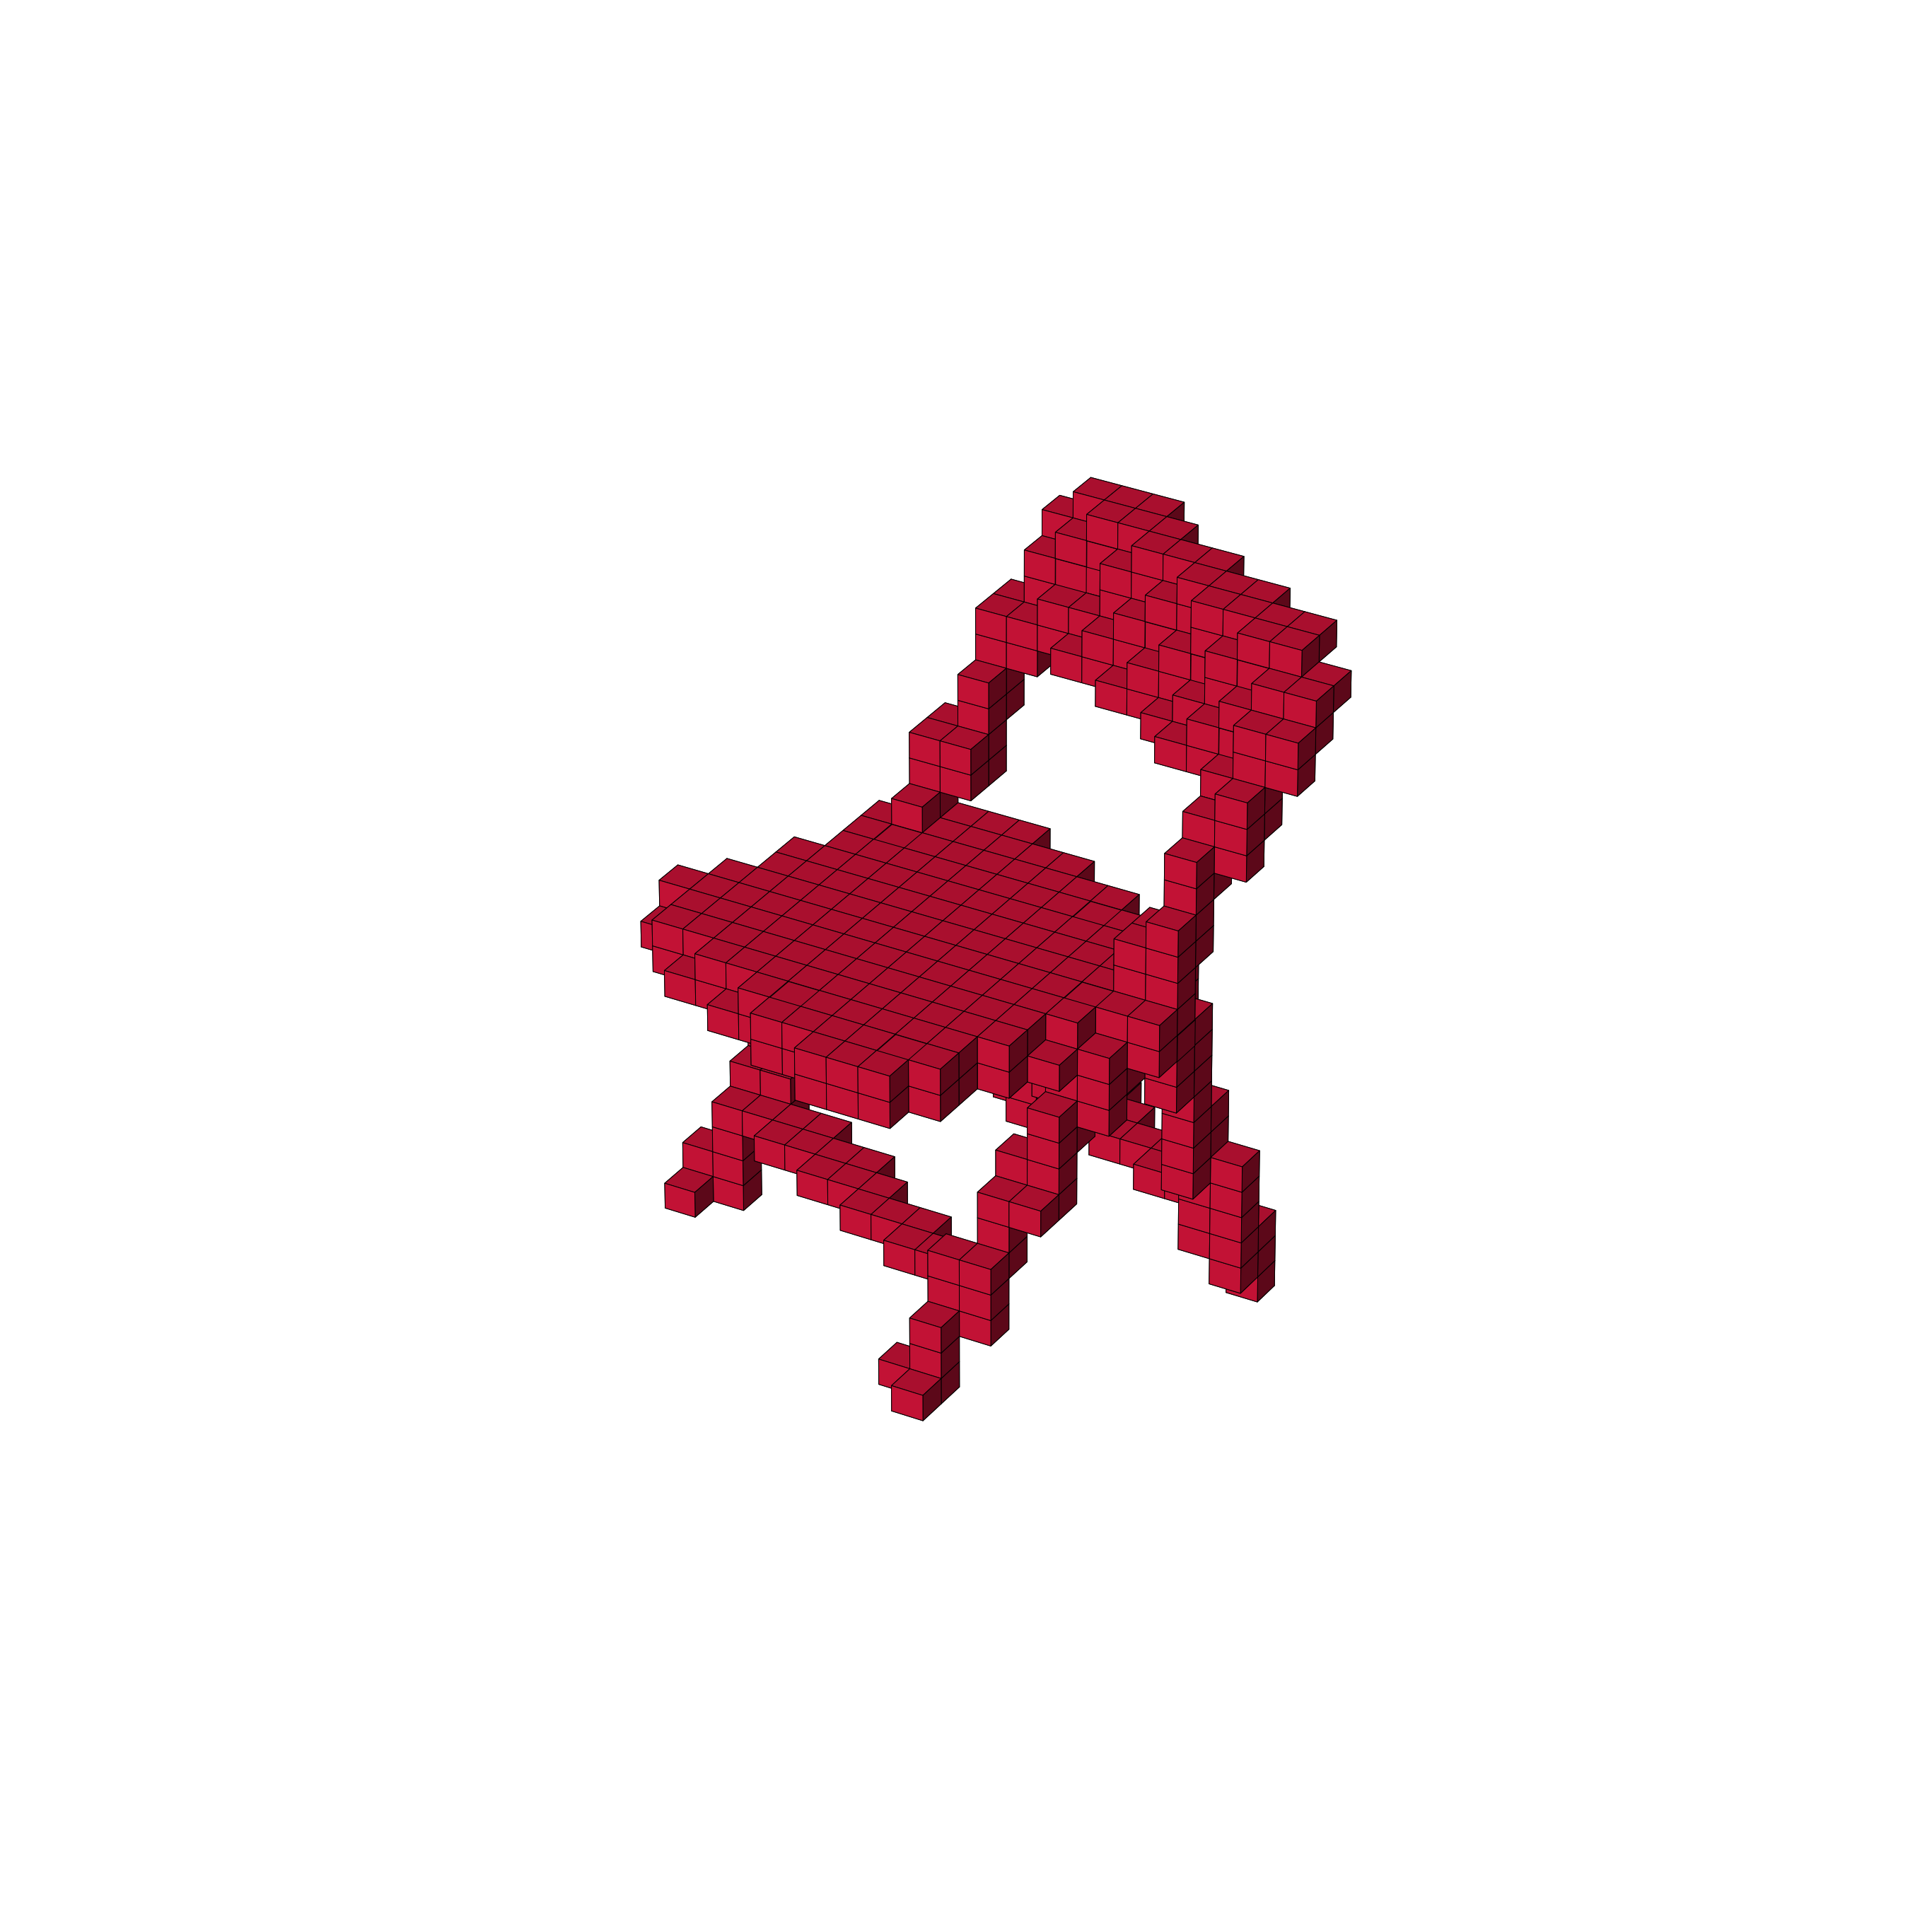

In [11]:
mesh_path = data_path+'chair_000000182_3.mat'
vox = GetVox(mesh_path)
visualizeVxl(vox)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

2022-09-01 11:06:22.920020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 11:06:22.920053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [14]:
def make_npy_df():
    objects = list(os.walk('../data/raw/chair/30/train/'))[0][2]
    for obj in objects:
        vox = GetVox('../data/raw/chair/30/train/'+obj)
        np.save('../data/processed/'+obj.split('.')[0],vox)

In [15]:
# make_npy_df() #call once

In [16]:
data_path = '../data/processed/'
data = np.array([np.load(data_path+x,allow_pickle=True) for x in list(os.walk(data_path))[0][2]  ])
# let's take only 300 of them 
data = data[:300,:,:,:]

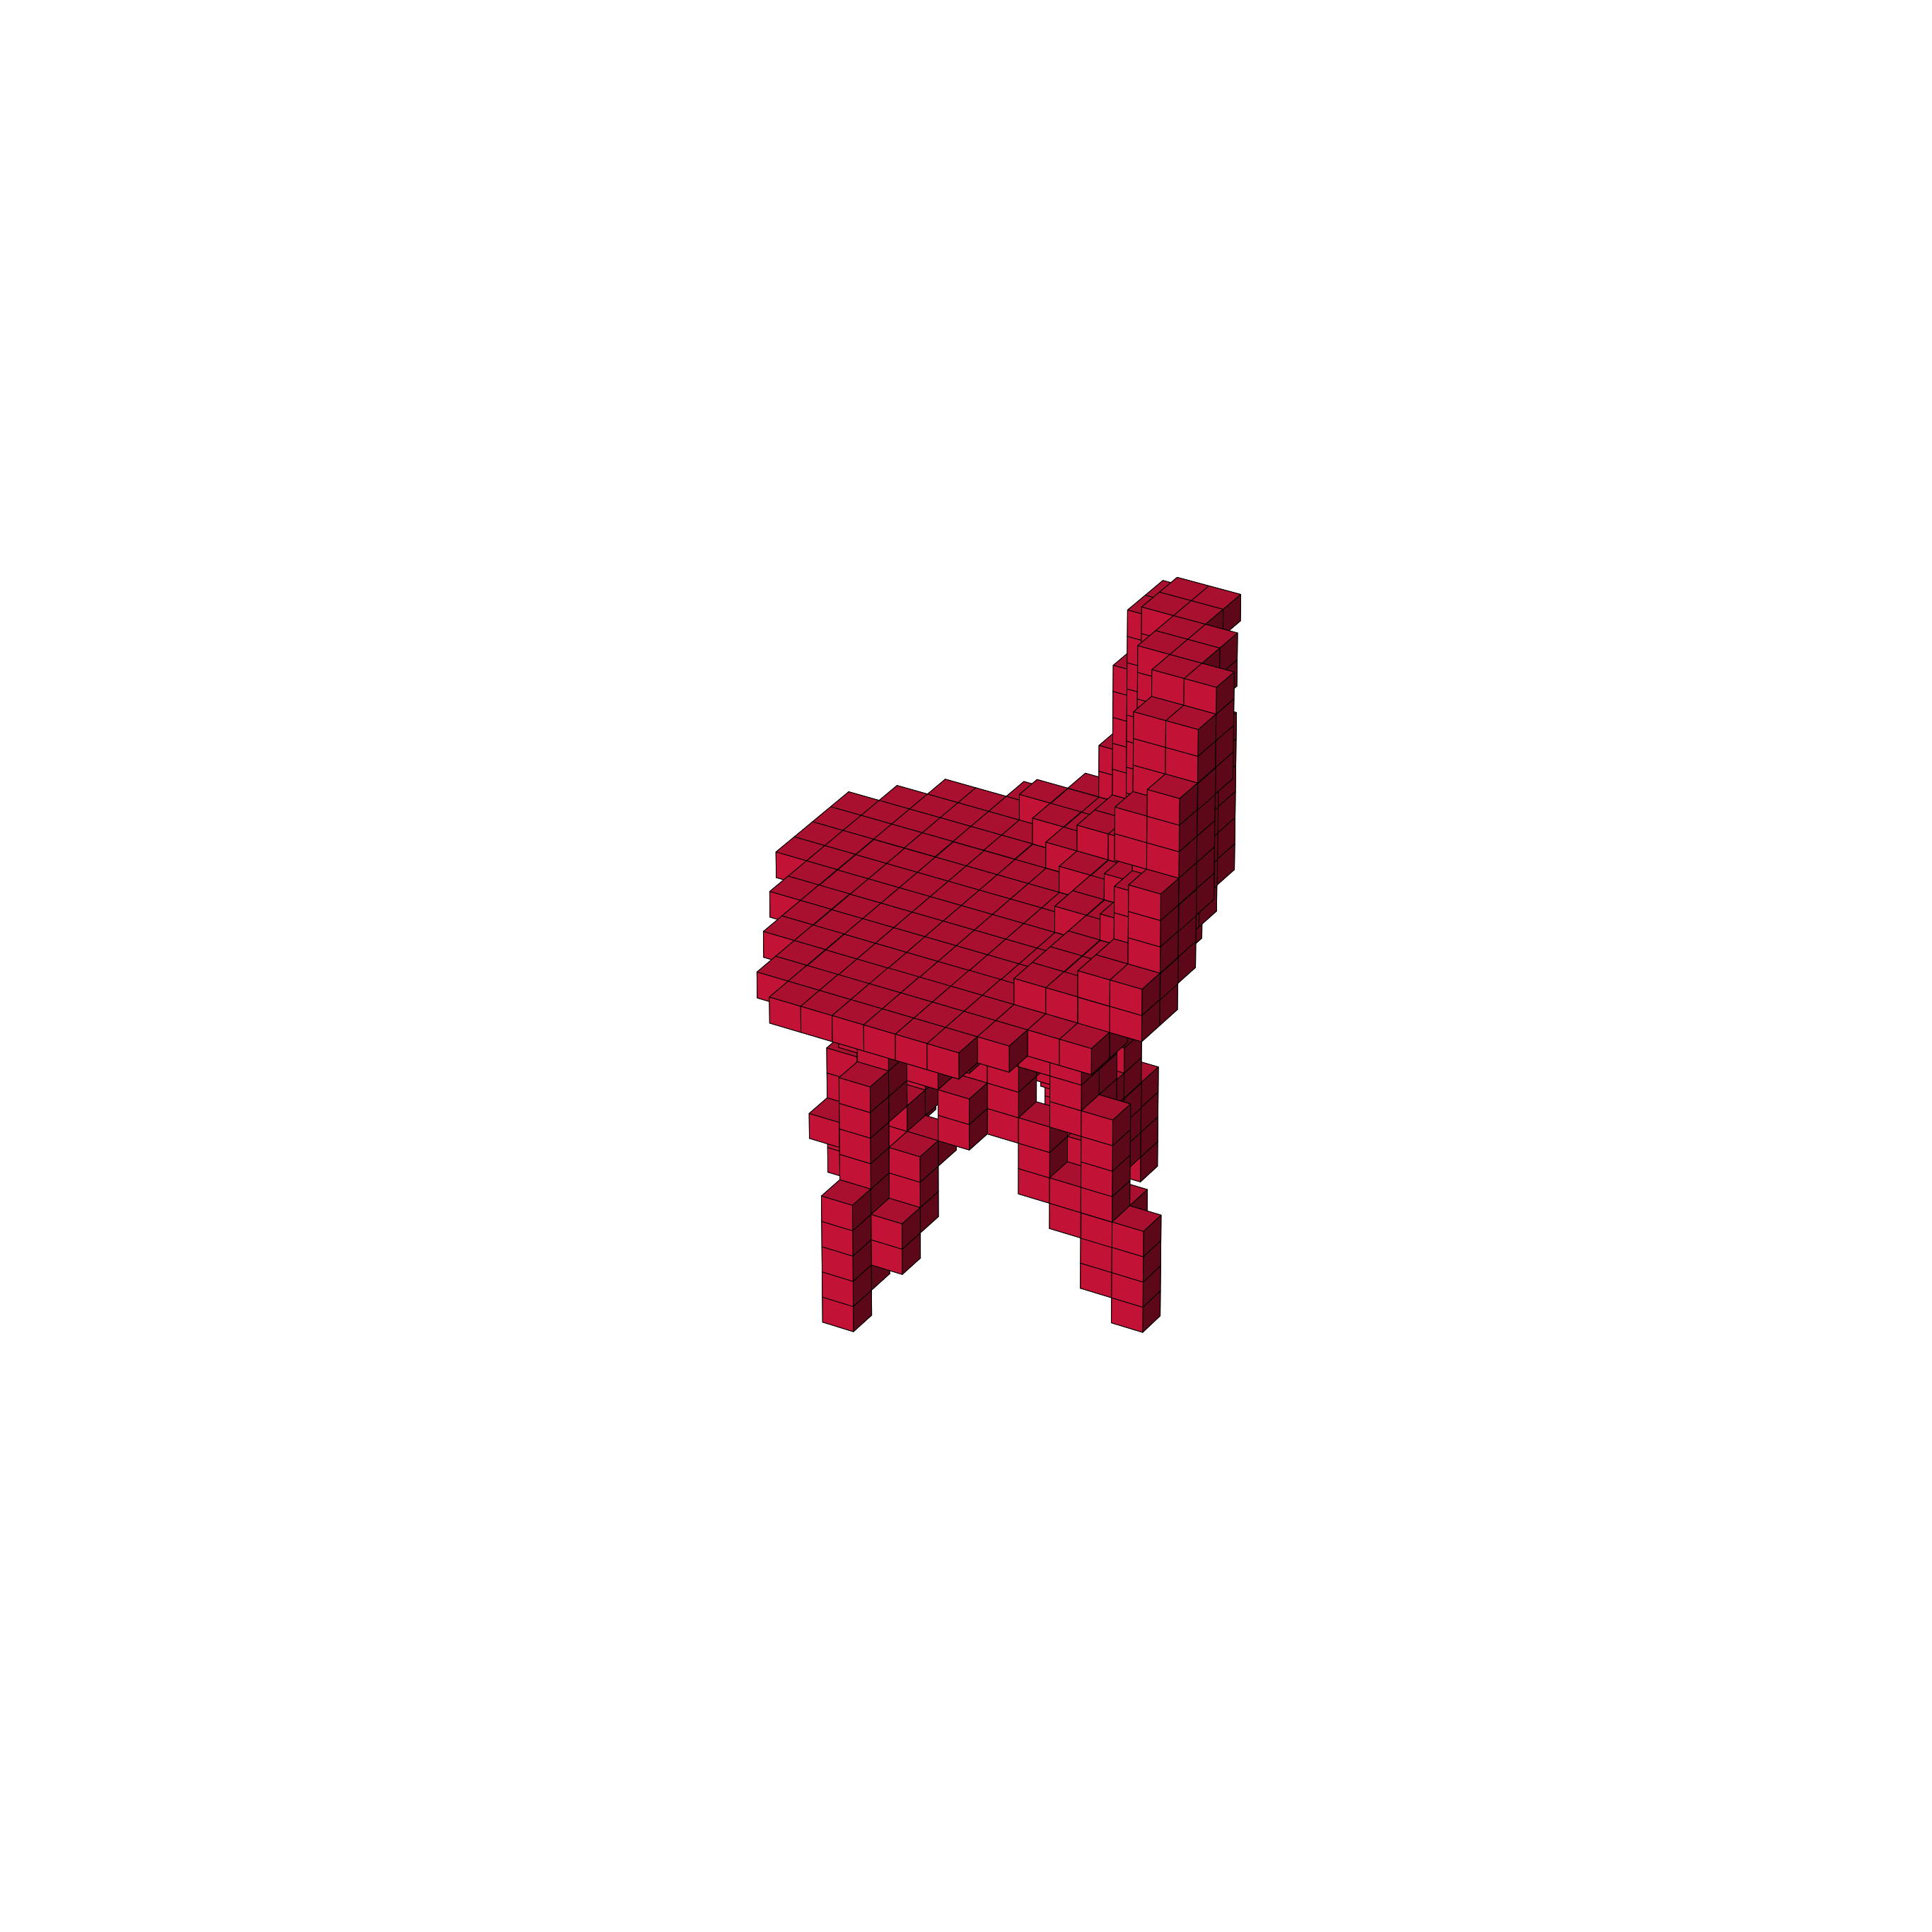

In [17]:
visualizeVxl(data[1])

In [18]:
def fakeData(n_samples):
    fakeData = []
    for i in range(n_samples):
        rand = np.random.random((30,30,30))
        rand[rand>.5] = 1
        rand[rand<=.5] = 0
        fakeData.append(rand)
    return np.array(fakeData)

In [19]:
def prepareData(data):
    target1 = np.ones((len(data)),dtype=int)
    target1.shape = (target1.shape[0],1)
    target0 = np.zeros((len(data)),dtype=int)
    target0.shape = (target0.shape[0],1)
    target = np.hstack([target1,target0])
    data.shape = (len(data),1,30,30,30)
    data_fake = fakeData(200)
    data_fake.shape = (len(data_fake),1,30,30,30) 
    target_fake0 = np.zeros((len(data_fake)),dtype=int)
    target_fake0.shape = (target_fake0.shape[0],1)
    target_fake1 = np.ones((len(data_fake)),dtype=int)
    target_fake1.shape = (target_fake1.shape[0],1)
    target_fake = np.hstack([target_fake0,target_fake1])
    full_data = np.vstack([data,data_fake])
    full_target = np.vstack([target,target_fake])
#     full_target.shape
#     target.shape
    return full_data,full_target

full_data,full_target = prepareData(data)

# La costruction du Discriminateur 

In [20]:
disc_model = Sequential([
    layers.Conv3D(16, (3,3,3), activation='relu', padding='same', input_shape=(1, 30,30,30)),
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
#     layers.MaxPooling3D((2,2,2), padding='same'),
    
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv3D(128, (3,3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv3D(128, (3,3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    layers.Dense(units = 256, activation='relu'),
    layers.BatchNormalization(),
#     layers.MaxPooling3D((2,2,2), padding='same'),
    
#     layers.Conv3D(16, (3,3,3), activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.GlobalAveragePooling3D(),
    layers.Flatten(),
    
#     layers.Dense(units=1024, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(units=256, activation='relu'),
#     layers.Dropout(0.4),
    layers.Dense(units=2, activation='sigmoid'),
])

2022-09-01 11:06:29.401725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 11:06:29.401750: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 11:06:29.401767: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bahrikhalid-ThinkPad-X1-Carbon-6th): /proc/driver/nvidia/version does not exist
2022-09-01 11:06:29.401956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
disc_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
disc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 1, 30, 30, 16)     12976     
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 30, 30, 32)     13856     
                                                                 
 batch_normalization (BatchN  (None, 1, 30, 30, 32)    128       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 30, 30, 64)     55360     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 30, 30, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_3 (Conv3D)           (None, 1, 30, 30, 128)    2

/home/bahri-khalid/anaconda3/envs/ml/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
# history = disc_model.fit(full_data, full_target,
#             batch_size=128,
#             epochs=40,
#             verbose=1,
#             validation_split=0.3)

# La construction d'Encodeur

In [23]:
encd_model = Sequential([
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same', input_shape=(1, 30,30,30)),
    layers.BatchNormalization(),
    
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same', input_shape=(1, 30,30,30)),
    layers.BatchNormalization(),
    
    layers.Conv3D(128, (3,3,3), activation='relu', padding='same', input_shape=(1, 30,30,30)),
    layers.BatchNormalization(),
    
    layers.Dense(units=256,activation='relu'),
    layers.BatchNormalization()
    
])

In [24]:
encd_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
encd_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 1, 30, 30, 32)     25952     
                                                                 
 batch_normalization_5 (Batc  (None, 1, 30, 30, 32)    128       
 hNormalization)                                                 
                                                                 
 conv3d_6 (Conv3D)           (None, 1, 30, 30, 64)     55360     
                                                                 
 batch_normalization_6 (Batc  (None, 1, 30, 30, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 1, 30, 30, 128)    221312    
                                                                 
 batch_normalization_7 (Batc  (None, 1, 30, 30, 128)  

In [25]:
# history = disc_model.fit(full_data, full_target,
#             batch_size=128,
#             epochs=40,
#             verbose=1,
#             validation_split=0.3)